<center><h1>Classifying Chest X-Rays</h1><h5>Wilbert Garcia, Madelyn Gatchel, Nyjay Nelson</h5><img src="pneumonia.jpeg" alt="Pneumonia Chest X-Ray">
</center>


### **Problem Explanation**

Deep Learning can be used to determine the presence of pneumonia in the lungs. This project comes from a Kaggle contest where the objective is to use computer vision techniques to identify medical diagnoses of treatable diseases, specifically pneumonia. The dataset used is of chest x-ray images. The dataset is checked for labelling accuracy by three experts. The dataset is divided into two classes of image. One class designating chest x-ray images with pneumonia and chest x-ray images that are normal. 

For our project, we are experimenting with a range of deep learning techniques available for image classification from building convolutional neural networks from scratch to using transfer learning models in order to perform binary classification on the dataset. The goal is to train a deep neural network that generalizes well to new data (new xrays) and can help doctors determine whether a given patient has pneumonia.

### **Related Work**

We trained a deep convolutional neural network from scratch. We began with the successful architecture used from the MNIST Image classification assignment. We were able to achieve 97.4% validation accuracy using this architecture and 95.2% test accuracy on the kuzushiji dataset while performing MNIST Image classification. 

We also trained a deep convolutional neural network that is inspired by a Kaggle notebook in the Chest X-ray Images (Pneumonia) contest. After looking over different architectures for convolutional neural networks that seemed useful and interesting, we were inspired by a model by Madz2000. The model is titled [Pneumonia Detection using CNN(92.6% Accuracy)](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy). 

The goal of this assignment is to train a deep network but deep networks are very difficult to train as they require much more data, computing power and time. We can avoid the issues of training a network from scratch by taking advantage of large neural networks that others have already trained using training learning models. 

We employ three transfer learning models offered by Keras from a collection of deep learning models that are available with pre-trained weights. We use th [VGG16 model](https://keras.io/api/applications/vgg/#vgg16-function), the [InceptionV3](https://keras.io/api/applications/inceptionv3/) model and the [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function) model. Each model is pre-trained using the ImageNet. ImageNet is a fairly comprehensive dataset. It features millions of images and thousands of different classes. An Image classification model that is trained on ImageNet and performs with significant accuracy generalizes well to new data and is not subject to overfitting. This is an attractive transfer learning model for the pneumonia image classification problem that we are attempting to solve. 

### **Pre-Processing**

There are 5,863 images in the dataset. They are high-resolution images that differ in size and content. Some images feature annotations while other images do not. The data was loaded and imported using the [ImageDataGenerator](https://keras.io/api/preprocessing/image/) class. The data is divided into training and testing sets.

For data preprocessing, we also use the ImageDataGenerator class which generates batches of tensor image data. It takes a data path to a directory & generates batches of augmented data. The ImageDataGenerator class returns a Directory Iterator. which is a directory that is able to read images from a directory. This directory iterator is composed of tuples of (x, y) where x is a numpy array containing a batch of images. The shape of this numpy array is(batch_size, target_size, channels). The y component of the tuple is a numpy array of corresponding labels. 

The ImageDataGenerator class is useful in data augmentation. It provides a range of arguments that perform a variety of data augmentation operations. In order to account for the smaller dataset size, we perform multiple data augmentation transformations as we preprocess the dataset. For this project, we varied the following data augmentation parameters:
   
* `rotation_range`: "Int. Degree range for random rotations."
* `shear_range`: "Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)"
* `zoom_range`: "Float or [lower, upper]. Range for random zoom."
* `horizontal_flip`: "Boolean. Randomly flip inputs horizontally."
* `vertical_flip`: "Boolean. Randomly flip inputs vertically."

Parameter descriptions are quoted from the Tensorflow ImageDataGenerator [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Also note that we perform a rescale operation by multiplying the pixel values in each image by 1/255 which essentially normalizes the data. 

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Informal experimentation showed that varying the batch size and steps per epoch did not seem to have a significant effect on the results, so in order to avoid OOM errors, we conducted all experiments with constant `BATCH_SIZE=32` and `TRAIN_STEPS=50`. If we had had more time and had not had OOM issues, we would have varied these values in our experiments, and it is quite possible that varying these two hyperparameters could give us a better model and better results.

In [8]:
training_path = "chest_xray/train"
test_path = "chest_xray/test"
labels = ['PNEUMONIA', 'NORMAL']
BATCH_SIZE = 32
TRAIN_STEPS = 50
VERBOSE=2 # 0 prints nothing, 1 prints everything, 2 prints one-line summary per epoch

Next, we create our training and testing generators. Since we want to compare model performance when data is augmented vs when it's not, we will create one training generator where the data is augmented and another training generator where the data is not. Note that the `class_mode` is set to `"binary"` since our problem is a binary classification problem.

We also set `shuffle=False` in `test_generator` and set `TEST_STEPS` equal to the number of samples divided by the batch size so that the testing set is always the same and the generator does not generate any new samples. 

In [9]:
# TRAINING GENERATORS
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, shear_range=0.0, zoom_range=0.0, 
                                   horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(training_path, target_size=(256, 256), classes = labels, 
                                                    batch_size = BATCH_SIZE, class_mode='binary', shuffle=True)

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=90, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)
train_generator_aug = train_datagen_aug.flow_from_directory(training_path, target_size=(256, 256), classes = labels, 
                                                    batch_size = BATCH_SIZE, class_mode='binary', shuffle=True)

Found 5235 images belonging to 2 classes.
Found 5235 images belonging to 2 classes.


In [10]:
# TESTING GENERATOR
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(256, 256), classes = labels,
                                                  batch_size = BATCH_SIZE, class_mode='binary', shuffle=False)
y_test = test_generator.classes
TEST_STEPS = np.math.ceil(test_generator.samples / BATCH_SIZE)

Found 631 images belonging to 2 classes.


### **Experiments**
#### **Model Architectures** 


  * The models outlined below can be found in `model.py`. This file contains functions to create and compile each model. User can output a model summary by changing `print_summary=False` to `True` in the `get_model()` function call. Since we had success with transfer learning models in project 5 (Binary Classification of Pneumonia using X-ray Images) and this is a harder learning problem, we decided to use transfer learning models for this project as well.
     
    * `baseline_model`: This model contains a singular sigmoid classification layer and serves as a basline because in theory no other (more complex) model should perform worse than this model. 
    * `proj3_model`: Our best-performing model from kuzushiji.ipynb; used as next starting point since we know how it has performed on related classification task
    * `kaggle_model`: Model inspired by a [Kaggle notebook](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy) in the Chest X-ray Images (Pneumonia) contest; uses batch normalization and max pool layers in addition to convolution layers
    
    * `inceptionv3_model`: The [InceptionV3](https://arxiv.org/abs/1512.00567) architecture that focuses on optimizing the computation power of the network using factorized convolutions, regularization techniques and aiming for a small number of parameters. The [InceptionV3](https://blog.paperspace.com/popular-deep-learning-architectures-resnet-inceptionv3-squeezenet/) model is a convolutional network that uses factorized convolutions to improve computational efficiency. The architecture uses smaller convolutions that lead to faster training of the model and asymmetric convolutions that result in using less parameters. InceptionV3 uses an auxillary classifier as regularizer. We chose the Inception V3 architecture as one of the transfer learning models in our experiment because it achieved Top-1 Accuracy of 0.779 and Top-5 Accuracy of 0.937 which represent the performance of the model on the ImageNet validation set.
    
    * `resnet50_model`: The [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) architecture is a residual network that allows for a substantially deeper network than other networks. The ResNet50 architecture is made up of 50 layers made up of residual blocks with skip connections that allow inputs to forward propagate faster through the residual connection across layers making the initial training more useful throughout the deep residual network. We chose the ResNet50 architecture because it achieved Top-1 Accuracy of 0.749 and Top-5 Accuracy of 0.921 which represent the performance of the model on the ImageNet validation set. We also found it attractive that while ResNet models are much deeper than VGG models, they are still less complex making for an attractive model.
       
    * `vgg16_model`: The [VGG16](https://arxiv.org/pdf/1409.1556.pdf) [architecture](https://neurohive.io/en/popular-networks/vgg16/) is a convolutional neural network created by the Visual Geometry group at the University of Oxford. The model has 22 layers of five convolutional blocks followed by three fully connected dense layers and an output layer. The first two convolutional blocks are made up of two convolutional layers with ReLu activation and max pooling layer. The three convolutional blocks that follow are made up of three convolutional layers with ReLu activation and max pooling layer. The Dense layers also have ReLu activation and the output layer uses a softmax activation function. We chose the VGG16 architecture as one of the transfer learning models in our experiment because it achieved Top-1 Accuracy of 0.713 and Top-5 Accuracy of 0.901 which represent the performance of the model on the ImageNet validation set.

In the cell below, we create and compile each model using the corresponding function in `model.py.` In terms of architecture, each of the three transfer models includes the transfer model layers, a dense layer with ReLU activation, a dropout layer, and the softmax classification layer. For now, you can ignore the other keyword arguments (they are the optimal hyperparameter settings based on the experiments we ran). Note that we have two instances of each model, one with the optimized hypeperameters trained on augmented data and the other trained on unagumented data. Also, since we could not get our Kaggle-inspired model to work, we have decided to not run the model in this writeup (but we will still present our results). 

In [11]:
import model

In [12]:
# OPTIMAL MODELS TRAINED ON UNAUGMENTED DATA
baseline_model = model.get_baseline_model(learning_rate=0.001);
proj3_model = model.get_proj3_model(learning_rate=0.001);
inceptionv3_model = model.get_inception_model(num_nodes=64, dropout_rate=0.1, learning_rate=0.001);
resnet50_model = model.get_resnet50_model(num_nodes=64, dropout_rate=0.1, learning_rate=0.001);
vgg16_model = model.get_vgg16_model(num_nodes=512, dropout_rate=0.25, learning_rate=0.0001);

In [13]:
# OPTIMAL MODELS TRAINED ON AUGMENTED DATA
baseline_model_aug = model.get_baseline_model(learning_rate=0.0001);
proj3_model_aug = model.get_proj3_model(learning_rate=0.0001);
inceptionv3_model_aug = model.get_inception_model(num_nodes=256, dropout_rate=0.25, learning_rate=0.001);
resnet50_model_aug = model.get_resnet50_model(num_nodes=256, dropout_rate=0.1, learning_rate=0.001);
vgg16_model_aug = model.get_vgg16_model(num_nodes=512, dropout_rate=0.1, learning_rate=0.0001);

#### **Metrics** 
Because the classes are unbalanced and because the implications of false negatives and false positives are much greater in a medical context, we look at several metrics other than just binary accuracy to determine the best model:

* Confusion Matrix: $\begin{pmatrix}TP & FP \\ FN & TN \end{pmatrix}$
* Precision: $\frac{TP}{TP+FP}$
* Recall: $\frac{TP}{TP+FN}$
* F1 score: $\frac{2\cdot precision * recall}{precision + recall}$

#### **Experimental Specification**

In our experiments, we vary the following hyperparameters: 

| rotation_range | zoom_range | shear_range | horizontal_flip | vertical_flip | num_dense_nodes | dropout_percentage | learning_rate |   
|------|----|----|------|---|---|---|---|
| 0, 90 | 0.0, 0.2 | 0.0, 0.2 | False, True | False, True | 64, 256, 512| .1, .25 | .001, .0001 | 

For each experiment and each model, we trained 5 epochs at a time until the loss stopped decreasing and/or the accuracy and or f1 scores decreased. Then, we recorded the previous number of epochs. Our results can be found in `experiments.ipynb`. 

We now show how the optimized models which have the best hyperparameter settings for each model compare against each other. We apologize for having so many cells/lines of code in the next section, but we think this is the best way to present the information while still giving the user the flexibility to mess around with things if needed.

**Baseline Model**

In [14]:
# Baseline model (trained on unaugmented data)
baseline_model.fit(train_generator, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
baseline_pred = baseline_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_00, precision_00, recall_00, f1_00, conf_mat_00 = model.print_results(y_test, baseline_pred)

Epoch 1/5
50/50 - 15s - loss: 2.1878 - binary_accuracy: 0.8075 - precision: 0.6343 - recall: 0.6130
Epoch 2/5
50/50 - 14s - loss: 0.5646 - binary_accuracy: 0.8944 - precision: 0.7922 - recall: 0.7941
Epoch 3/5
50/50 - 15s - loss: 0.5299 - binary_accuracy: 0.9075 - precision: 0.8256 - recall: 0.8294
Epoch 4/5
50/50 - 14s - loss: 0.8111 - binary_accuracy: 0.8834 - precision: 0.7781 - recall: 0.7568
Epoch 5/5
50/50 - 15s - loss: 0.7479 - binary_accuracy: 0.9038 - precision: 0.8095 - recall: 0.8213
20/20 [==============================] - 5s 251ms/step
Accuracy:  0.6307448494453248
Precision:  1.0
Recall:  0.02510460251046025
F1 score:  0.0489795918367347
Confusion Matrix:  [[392   0]
 [233   6]]


In [15]:
# Baseline model (trained on augmented data)
baseline_model_aug.fit(train_generator_aug, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
baseline_aug_pred = baseline_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_01, precision_01, recall_01, f1_01, conf_mat_01 = model.print_results(y_test, baseline_aug_pred)

Epoch 1/5
50/50 - 34s - loss: 0.8457 - binary_accuracy: 0.7894 - precision: 0.6135 - recall: 0.5467
Epoch 2/5
50/50 - 33s - loss: 0.5936 - binary_accuracy: 0.7275 - precision: 0.4510 - recall: 0.3162
Epoch 3/5
50/50 - 33s - loss: 0.4181 - binary_accuracy: 0.8144 - precision: 0.6962 - recall: 0.4231
Epoch 4/5
50/50 - 33s - loss: 0.4020 - binary_accuracy: 0.8299 - precision: 0.7394 - recall: 0.5172
Epoch 5/5
50/50 - 33s - loss: 0.4069 - binary_accuracy: 0.8200 - precision: 0.7368 - recall: 0.5185
20/20 [==============================] - 5s 252ms/step
Accuracy:  0.6307448494453248
Precision:  1.0
Recall:  0.02510460251046025
F1 score:  0.0489795918367347
Confusion Matrix:  [[392   0]
 [233   6]]


**Project 3 Model**

In [16]:
# Project 3 model (trained on unaugmented data)
proj3_model.fit(train_generator, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
proj3_pred = proj3_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_10, precision_10, recall_10, f1_10, conf_mat_10 = model.print_results(y_test, proj3_pred)

Epoch 1/5
50/50 - 14s - loss: 0.6885 - binary_accuracy: 0.8097 - precision: 0.6696 - recall: 0.5411
Epoch 2/5
50/50 - 15s - loss: 0.2667 - binary_accuracy: 0.8922 - precision: 0.8037 - recall: 0.7618
Epoch 3/5
50/50 - 15s - loss: 0.1290 - binary_accuracy: 0.9506 - precision: 0.9200 - recall: 0.8756
Epoch 4/5
50/50 - 14s - loss: 0.1296 - binary_accuracy: 0.9531 - precision: 0.9136 - recall: 0.9024
Epoch 5/5
50/50 - 15s - loss: 0.1171 - binary_accuracy: 0.9553 - precision: 0.9246 - recall: 0.9048
20/20 [==============================] - 5s 253ms/step
Accuracy:  0.7337559429477021
Precision:  0.7005649717514124
Recall:  0.5188284518828452
F1 score:  0.5961538461538461
Confusion Matrix:  [[339  53]
 [115 124]]


In [17]:
# Project 3 model (trained on augmented data)
proj3_model_aug.fit(train_generator_aug, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
proj3_aug_pred = proj3_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_11, precision_11, recall_11, f1_11, conf_mat_11 = model.print_results(y_test, proj3_aug_pred)

Epoch 1/5
50/50 - 33s - loss: 0.8212 - binary_accuracy: 0.8381 - precision: 0.7522 - recall: 0.5402
Epoch 2/5
50/50 - 33s - loss: 0.4732 - binary_accuracy: 0.7801 - precision: 0.8725 - recall: 0.2094
Epoch 3/5
50/50 - 33s - loss: 0.3927 - binary_accuracy: 0.8200 - precision: 0.8251 - recall: 0.3710
Epoch 4/5
50/50 - 33s - loss: 0.3176 - binary_accuracy: 0.8650 - precision: 0.7967 - recall: 0.6667
Epoch 5/5
50/50 - 33s - loss: 0.2976 - binary_accuracy: 0.8715 - precision: 0.7692 - recall: 0.7000
20/20 [==============================] - 5s 252ms/step
Accuracy:  0.6418383518225039
Precision:  0.536723163841808
Recall:  0.39748953974895396
F1 score:  0.4567307692307692
Confusion Matrix:  [[310  82]
 [144  95]]


**InceptionV3 Transfer Learning Model**

In [18]:
# InceptionV3 transfer learning model (trained on unaugmented data)
inceptionv3_model.fit(train_generator, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
iv3_pred = inceptionv3_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_30, precision_30, recall_30, f1_30, conf_mat_30 = model.print_results(y_test, iv3_pred)

Epoch 1/5
50/50 - 15s - loss: 2.0203 - binary_accuracy: 0.8626 - precision: 0.7395 - recall: 0.7122
Epoch 2/5
50/50 - 14s - loss: 0.1363 - binary_accuracy: 0.9438 - precision: 0.8873 - recall: 0.8959
Epoch 3/5
50/50 - 14s - loss: 0.1228 - binary_accuracy: 0.9513 - precision: 0.9208 - recall: 0.8900
Epoch 4/5
50/50 - 15s - loss: 0.0798 - binary_accuracy: 0.9742 - precision: 0.9492 - recall: 0.9515
Epoch 5/5
50/50 - 14s - loss: 0.0729 - binary_accuracy: 0.9744 - precision: 0.9495 - recall: 0.9471
20/20 [==============================] - 6s 283ms/step
Accuracy:  0.5863708399366085
Precision:  0.39
Recall:  0.16317991631799164
F1 score:  0.23008849557522124
Confusion Matrix:  [[331  61]
 [200  39]]


In [19]:
# InceptionV3 transfer learning model (trained on augmented data)
inceptionv3_model_aug.fit(train_generator_aug, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
iv3_aug_pred = inceptionv3_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_31, precision_31, recall_31, f1_31, conf_mat_31 = model.print_results(y_test, iv3_aug_pred)

Epoch 1/5
50/50 - 33s - loss: 5.7402 - binary_accuracy: 0.8825 - precision: 0.7750 - recall: 0.7637
Epoch 2/5
50/50 - 33s - loss: 0.3161 - binary_accuracy: 0.8894 - precision: 0.8026 - recall: 0.7537
Epoch 3/5
50/50 - 33s - loss: 0.2366 - binary_accuracy: 0.9075 - precision: 0.8312 - recall: 0.7985
Epoch 4/5
50/50 - 34s - loss: 0.2277 - binary_accuracy: 0.9036 - precision: 0.8280 - recall: 0.8024
Epoch 5/5
50/50 - 33s - loss: 0.2155 - binary_accuracy: 0.9150 - precision: 0.8428 - recall: 0.8265
20/20 [==============================] - 5s 255ms/step
Accuracy:  0.5736925515055468
Precision:  0.35
Recall:  0.14644351464435146
F1 score:  0.20648967551622419
Confusion Matrix:  [[327  65]
 [204  35]]


**ResNet50 Transfer Learning Model**

In [20]:
# ResNet50 transfer learning model (trained on unaugmented data)
resnet50_model.fit(train_generator, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
resnet_pred = resnet50_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_40, precision_40, recall_40, f1_40, conf_mat_40 = model.print_results(y_test, resnet_pred)

Epoch 1/5
50/50 - 15s - loss: 1.4136 - binary_accuracy: 0.7897 - precision: 0.6527 - recall: 0.4550
Epoch 2/5
50/50 - 15s - loss: 0.5095 - binary_accuracy: 0.7423 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
50/50 - 14s - loss: 0.4252 - binary_accuracy: 0.7519 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/5
50/50 - 15s - loss: 0.4076 - binary_accuracy: 0.7344 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/5
50/50 - 14s - loss: 0.3875 - binary_accuracy: 0.7442 - precision: 0.0000e+00 - recall: 0.0000e+00
20/20 [==============================] - 6s 277ms/step
Accuracy:  0.6212361331220285
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Confusion Matrix:  [[392   0]
 [239   0]]


/home/DAVIDSON/magatchel/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# ResNet50 transfer learning model (trained on augmented data)
resnet50_model_aug.fit(train_generator_aug, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
resnet_aug_pred = resnet50_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_41, precision_41, recall_41, f1_41, conf_mat_41 = model.print_results(y_test, resnet_aug_pred)

Epoch 1/5
50/50 - 33s - loss: 2.9353 - binary_accuracy: 0.7283 - precision: 0.4319 - recall: 0.2066
Epoch 2/5
50/50 - 32s - loss: 0.6568 - binary_accuracy: 0.7662 - precision: 0.5109 - recall: 0.4934
Epoch 3/5
50/50 - 33s - loss: 0.5005 - binary_accuracy: 0.7781 - precision: 0.5897 - recall: 0.4201
Epoch 4/5
50/50 - 33s - loss: 0.3837 - binary_accuracy: 0.8131 - precision: 0.6757 - recall: 0.4963
Epoch 5/5
50/50 - 34s - loss: 0.3572 - binary_accuracy: 0.8355 - precision: 0.7348 - recall: 0.6510
20/20 [==============================] - 5s 253ms/step
Accuracy:  0.6212361331220285
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Confusion Matrix:  [[392   0]
 [239   0]]


**VGG16 Transfer Learning Model**

In [22]:
# VGG16 transfer learning model (trained on unaugmented data)
vgg16_model.fit(train_generator, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
vgg_pred = vgg16_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_50, precision_50, recall_50, f1_50, conf_mat_50 = model.print_results(y_test, vgg_pred)

Epoch 1/5
50/50 - 15s - loss: 0.2049 - binary_accuracy: 0.8754 - precision: 0.7845 - recall: 0.7356
Epoch 2/5
50/50 - 14s - loss: 0.0815 - binary_accuracy: 0.9719 - precision: 0.9381 - recall: 0.9499
Epoch 3/5
50/50 - 15s - loss: 0.0696 - binary_accuracy: 0.9729 - precision: 0.9529 - recall: 0.9463
Epoch 4/5
50/50 - 15s - loss: 0.0612 - binary_accuracy: 0.9775 - precision: 0.9648 - recall: 0.9514
Epoch 5/5
50/50 - 15s - loss: 0.0496 - binary_accuracy: 0.9812 - precision: 0.9594 - recall: 0.9643
20/20 [==============================] - 6s 299ms/step
Accuracy:  0.5213946117274167
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Confusion Matrix:  [[329  63]
 [239   0]]


In [23]:
# VGG16 transfer learning model (trained on unaugmented data)
vgg16_model_aug.fit(train_generator_aug, batch_size=BATCH_SIZE, steps_per_epoch=TRAIN_STEPS, epochs= 5, verbose=VERBOSE)
vgg_aug_pred = vgg16_model.predict(test_generator, verbose=1, steps=TEST_STEPS)
accuracy_51, precision_51, recall_51, f1_51, conf_mat_51 = model.print_results(y_test, vgg_aug_pred)

Epoch 1/5
50/50 - 33s - loss: 0.4209 - binary_accuracy: 0.8997 - precision: 0.8143 - recall: 0.7609
Epoch 2/5
50/50 - 34s - loss: 0.2389 - binary_accuracy: 0.8994 - precision: 0.8089 - recall: 0.8292
Epoch 3/5
50/50 - 33s - loss: 0.2221 - binary_accuracy: 0.9023 - precision: 0.8035 - recall: 0.8095
Epoch 4/5
50/50 - 34s - loss: 0.2032 - binary_accuracy: 0.9225 - precision: 0.8581 - recall: 0.8581
Epoch 5/5
50/50 - 34s - loss: 0.2060 - binary_accuracy: 0.9112 - precision: 0.8258 - recall: 0.8488
20/20 [==============================] - 5s 251ms/step
Accuracy:  0.5213946117274167
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Confusion Matrix:  [[329  63]
 [239   0]]


### **Results and Conclusion**
First, let's gather the results from each model and plot the results:

In [24]:
model_names = ["Baseline", "Baseline aug", "Proj3", "Proj3 aug", "Inceptionv3", "Inceptionv3", "ResNet50", "ResNet50 aug", "VGG16", "VGG16 aug"]
acc_list = [accuracy_01, accuracy_11, accuracy_10, accuracy_11, accuracy_30, accuracy_31, accuracy_40, accuracy_41, accuracy_50, accuracy_51]
prec_list = [precision_01, precision_11, precision_10, precision_11, precision_30, precision_31, precision_40, precision_41, precision_50, precision_51]
rec_list = [recall_01, recall_11, recall_10, recall_11, recall_30, recall_31, recall_40, recall_41, recall_50, recall_51]
f1_list = [f1_01, f1_11, f1_10, f1_11, f1_30, f1_31, f1_40, f1_41, f1_50, f1_51]
pred_list = [baseline_pred, baseline_aug_pred, proj3_pred, proj3_aug_pred, iv3_pred, iv3_aug_pred, resnet_pred, resnet_aug_pred, vgg_pred, vgg_aug_pred]

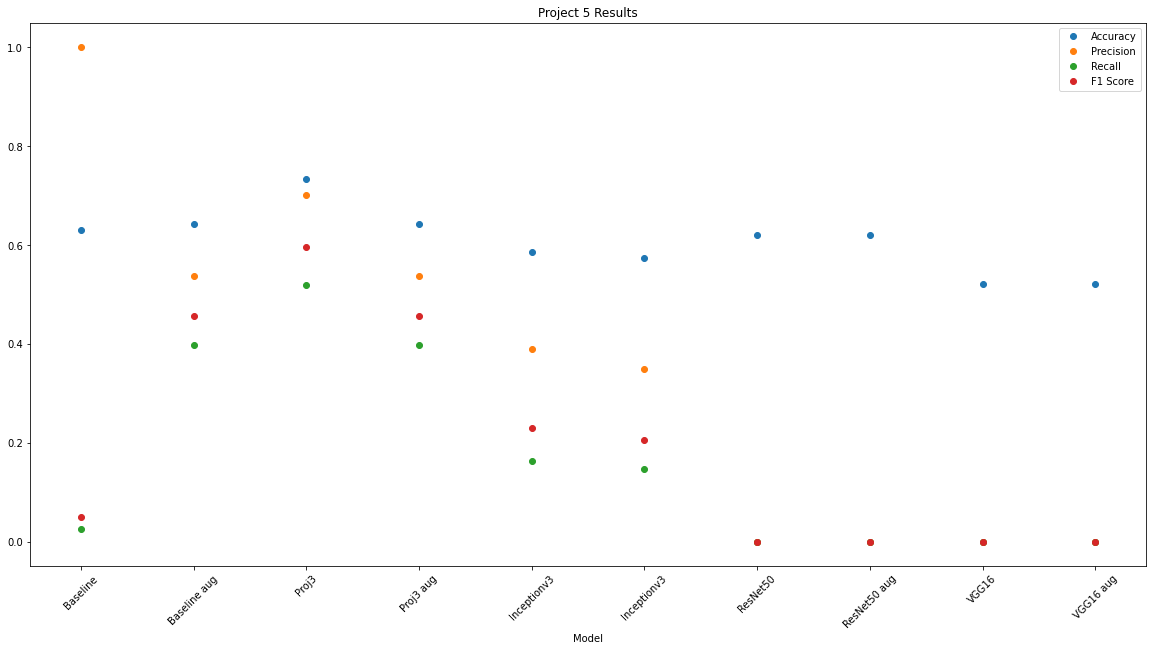

In [25]:
model.plot_results(acc_list, prec_list, rec_list, f1_list, model_names)

Now, let's plot the ROC curve for the models:

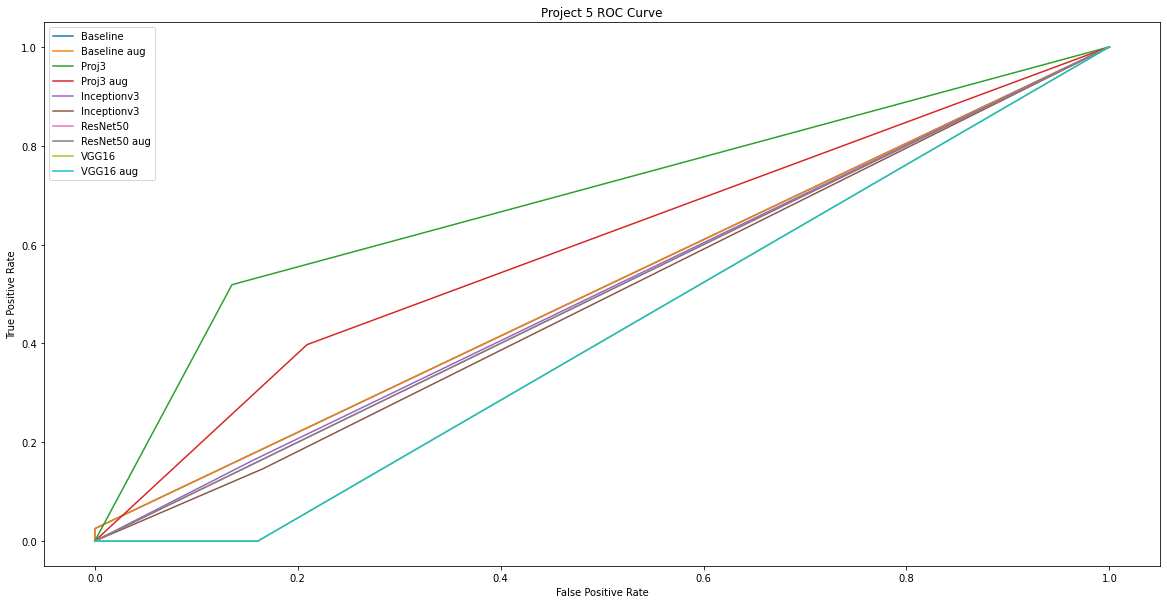

In [27]:
model.plot_roc_curve(y_test, pred_list, model_names)

We recognize that there are lots of aspects about our results that are a bit odd or surprising. First, we are unsure why the results in this notebook are so much lower than all the experimental results from running in other notebooks. This did not happen until we had two separate generators, so there is a possibility that something odd is happening with the two different generators. Feel free to look at `madelyn_testing5.ipynb` to see that the results were not usually this low. It is also odd that our best F1 score out of all the experiments we ran was achieved by the baseline model. In theory, we think this should mean that the more complex models are not needed and that the complexity of these models caused their accuracy and F1 scores to be lower. However, we are not convinced that this is the case. We evaluated this baseline model on the test set several times, and most of the time the F1 scores were similar, however every so often the F1 scores would be horrible, which could indicate that the model does not generalize as well to new data as the higher F1 score indicates. We also noticed this trend with the transfer learning models as well. Every so often, the precision, recall, and F1 scores for a transfer learning model would be exactly 0, but if you trained from scratch and reran, often the score would be back between .4 and .6 (note that we recorded the results from the first time running the model with those settings, even if the results were all 0). In all cases, we believe this is because the models are overfitting to the training data. We did perform some informal/unrecorded experiments with more extreme dropout layers to try to combat this overfitting, but were not successful. We also think the ROC curves look odd in that they are more like piecewise linear functions as opposed to actual curves. At this time, we are unsure what has caused this. Finally, we were a bit surprised that the data augmentation did not improve the model results as much as we thought it would. This might suggest that we did not test the most appropriate data augmentation parameter settings in our experiments. Overall, we believe that our models do not generalize well to new data and as a result should not be used to help doctors classify chest x-rays.

If we had had more time and had not had OOM errors at various points, we would have liked to run more experiments varying the data agumentation hyperparameters as well as the batch size and steps per epoch. We believe this might result in a much better model overall. That being said, we put a lot of time into this project and think that given the time and memory constraints, we did the best we could. 

### **References**
[1] https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia (This chest x-ray dataset was used to train and test our models)<br>
[2] https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy (This Kaggle model served as inspiration for our 3rd CNN model; it is interesting that their model worked so well and ours did not) <br>
[3] https://keras.io/api/preprocessing/image/ (this documentation helped us learn how to use the `ImageDataGenerator` class as well as how to use the `flow_from_directory` function)<br>
[4] https://keras.io/api/applications/ (this documentation helped us learn how to use Keras transfer learning models in order to create our own models) <br>
[5] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator (this documentation helped us better understand different data augmentation parameters and their effects on the dataset)<br>
[6] https://arxiv.org/abs/1512.00567 (this paper describes the inception model that we used as a part of our transfer learning model; we didn't read the details of this paper too closely because they weren't necessary for this project, but it was interesting to learn more about the model) <br>
[7] https://blog.paperspace.com/popular-deep-learning-architectures-resnet-inceptionv3-squeezenet/ (brief introduction to several transfer learning models including resnet and inception)<br>
[8] https://arxiv.org/pdf/1512.03385.pdf (this paper describes the resnet model that we used as a part of our transfer learning model that we tried to get working; we didn't read the details of this paper too closely because they weren't necessary for this project, but it was interesting to learn more about the model) <br>
[9] https://arxiv.org/pdf/1409.1556.pdf (this paper describes the vgg model that we used as a part of our transfer learning model; we didn't read the details of this paper too closely because they weren't necessary for this project, but it was interesting to learn more about the model)<br>
[10] https://neurohive.io/en/popular-networks/vgg16/ (this article provides a brief introduction to vgg16 and was helpful to get the most relevant and important details for the model)<br>